In [1]:
%pip install "git+https://github.com/jsbrittain/saccadapt.git#subdirectory=eye"
import eye as Eye
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from typing import List
matplotlib.use('nbagg')

%matplotlib inline

  Cloning https://github.com/jsbrittain/saccadapt.git to /tmp/pip-req-build-waquk98k
  Running command git clone --filter=blob:none --quiet https://github.com/jsbrittain/saccadapt.git /tmp/pip-req-build-waquk98k
  Resolved https://github.com/jsbrittain/saccadapt.git to commit 85c5d5de8260fbec1696081c6bad5b16ba1d7f19
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for eye: filename=eye-0.1.0-py3-none-any.whl size=3944 sha256=608332d7344da2bd6a173c0c3aa1459e814e6e44b9032bfbc180c8d24462d0d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5jkh76r/wheels/9e/c3/b9/73ffd62f0351151da04a178477d4ac9d85ead39e97c8d5228e
Successfully built eye


## Mount Google Drive then load eyelink data

Remove this section if you are uploading files manually.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

filename = "drive/MyDrive/sacc.adapt.data/IG.zero.lag.asc"

eye = Eye.Eye(filename)

Mounted at /content/drive


### Examine channel data

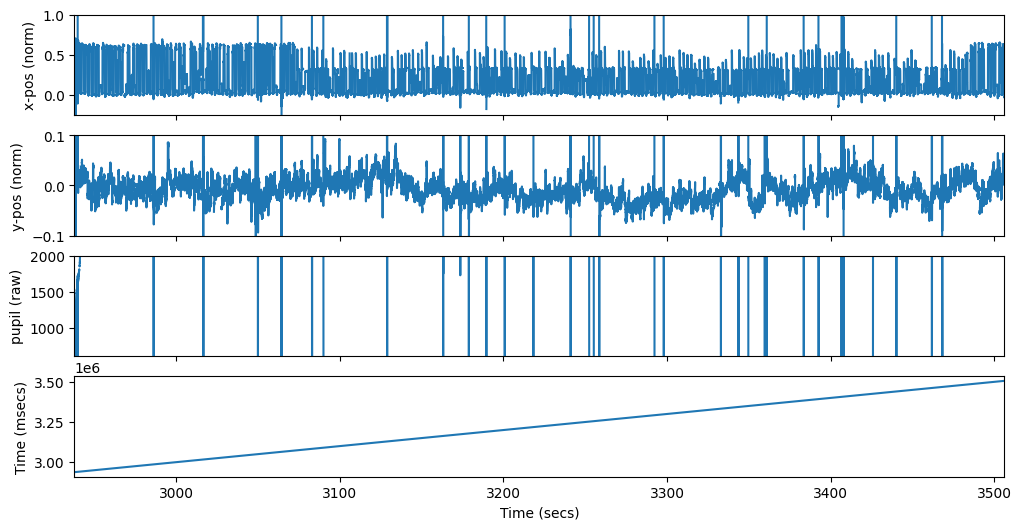

In [3]:
time_secs = eye.df['Time (msecs)']/1000
fig, axs = plt.subplots(len(eye.df.columns), figsize=(12, 6), sharex=True)
for k, colname in enumerate(eye.df.columns):
    axs[k].plot(time_secs, eye.df[colname])
    axs[k].set_ylabel(colname)
axs[0].set_xlim(time_secs.iloc[0], time_secs.iloc[-1])

axs[0].set_ylim(-0.25, 1.0)
axs[1].set_ylim(-0.1, 0.1)
axs[2].set_ylim(600, 2000)
axs[3].set_xlabel('Time (secs)')
fig.show()

### xy-trace

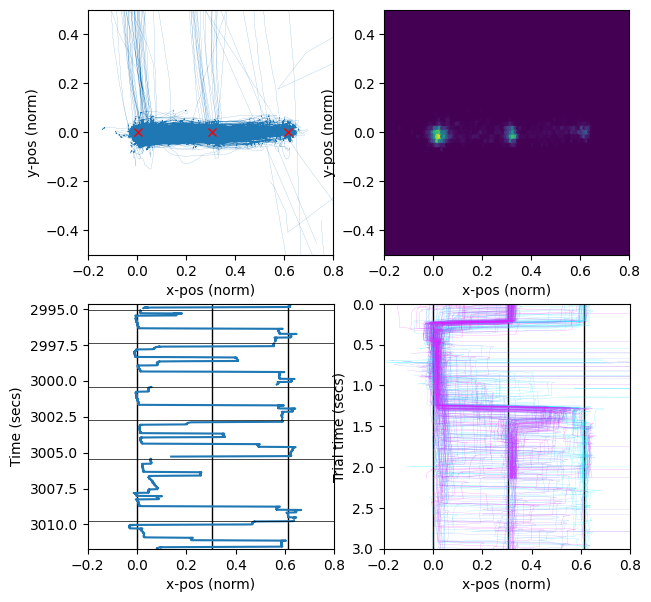

In [5]:
chx, chy = 'x-pos (norm)', 'y-pos (norm)'  # x, y

fig, axs = plt.subplot_mosaic(
    [['b','c'], ['a','d']],
    figsize=(7, 7),
)

# temporal segment
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['a'].plot(np.array([x, x]), [time_secs.iloc[0], time_secs.iloc[-1]], 'k-', linewidth=1)
axs['a'].plot(eye.df[chx], time_secs)
for start, end in zip(eye.trial.StartPos, eye.trial.EndPos):
  axs['a'].plot(np.array([-1, 1]), np.array([start, start])/eye._SAMPLE_RATE, 'k-', linewidth=0.5)
axs['a'].set_xlim(-0.2, 0.8)
axs['a'].set_xlabel(chx)
axs['a'].set_ylabel('Time (secs)')
axs['a'].set_ylim(
    time_secs.iloc[round(0.100*len(time_secs))],
    time_secs.iloc[round(0.130*len(time_secs))],
)
axs['a'].invert_yaxis()

# xy-trace
axs['b'].plot(eye.df[chx], eye.df[chy], linewidth=0.1)
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['b'].plot(x, y, 'rx')
axs['b'].set_aspect('equal', 'box')
axs['b'].set_xlim(-0.2, 0.8)
axs['b'].set_ylim(-0.5, 0.5)
axs['b'].set_xlabel(chx)
axs['b'].set_ylabel(chy)

# spatial histogram
axs['c'].hexbin(
    eye.df[chx],
    eye.df[chy],
    extent=(-0.2, 0.8, -0.5, 0.5),
)
axs['c'].set_aspect('equal', 'box')
axs['c'].set_xlim(-0.2, 0.8)
axs['c'].set_ylim(-0.5, 0.5)
axs['c'].set_xlabel(chx)
axs['c'].set_ylabel(chy)

# stack trials
for x, y in np.unique(np.array(eye._TARGET_POS), axis=0):
  axs['d'].plot(np.array([x, x]), np.array([0.0, 3.0]), 'k-', linewidth=1)
viridis = matplotlib.colormaps['cool']
for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
  axs['d'].plot(
      eye.df[chx].loc[start:end],
      time_secs.loc[start:end]-time_secs.loc[start],
      '-',
      linewidth=0.1,
      color=viridis(index/(len(eye.trial)-1)),
  )
axs['d'].set_ylabel('Trial time (secs)')
axs['d'].set_xlabel(chx)
axs['d'].set_xlim(-0.2, 0.8)
axs['d'].set_ylim(0, 3)
axs['d'].invert_yaxis()

fig.show()

## Extract per-trial metrics

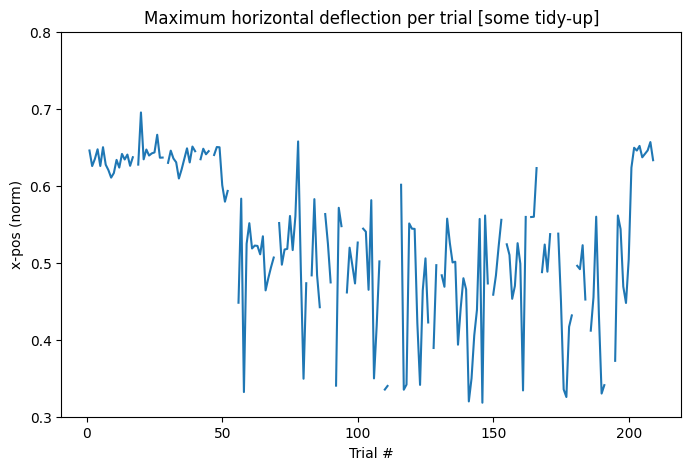

In [8]:
# Loop over trials
eye.trial['max_x'] = [0]*len(eye.trial)
for index, (start, end) in enumerate(zip(eye.trial.StartPos, eye.trial.EndPos)):
  eye.trial['max_x'].at[index] = max(eye.df[chx].loc[start:end])

# Plot metric
data = eye.trial['max_x']
data[data>0.8] = None  # Remove obvious outliers (for now)

fig, axs = plt.subplots(1, figsize=(8, 5), sharex=True)
axs.plot(data)
axs.set_ylim([0.3, 0.8])
axs.set_ylabel(chx)
axs.set_xlabel("Trial #")
axs.set_title("Maximum horizontal deflection per trial [some tidy-up]")

fig.show()

Text(0.5, 1.0, 'Inward delay time (median=150.5 msecs)')

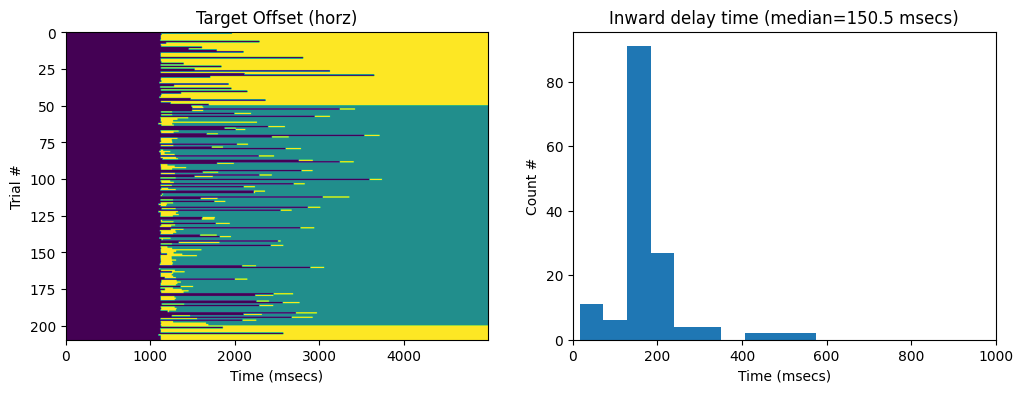

In [7]:
# Loop over trials
target_positions = [960, 1548, 1251]
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
count = 0
max_samples = 5000
x = 960 * np.ones((len(eye.trial), max_samples))
x_mean = np.zeros(max_samples)
inward_delay = []
for index in eye.trial.index:
  targets = eye.trial['Targets'].loc[index]
  last_target_time = 0
  outward_time = 0
  for t in targets:
    target_time, target_pos = int(t[0]-eye.trial['StartPos'].loc[index]), t[1]
    assert target_time > last_target_time
    last_target_time = target_time
    x[index, target_time:] = target_pos[0]
    if target_pos[0] == 1548:
      outward_time = target_time
    if target_pos[0] == 1251:
      inward_delay.append(target_time - outward_time)
  #axs.plot(x[:, index], 'k', linewidth=0.1)

axs[0].imshow(x, aspect='auto')
axs[0].set_xlabel('Time (msecs)')
axs[0].set_ylabel('Trial #')
axs[0].set_title("Target Offset (horz)")

axs[1].hist(inward_delay, 20)
axs[1].set_xlim(0, 1000)
axs[1].set_xlabel('Time (msecs)')
axs[1].set_ylabel('Count #')
axs[1].set_title(f"Inward delay time (median={np.median(inward_delay)} msecs)")
# fig.show()